In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from itertools import cycle
from sklearn.datasets import make_blobs
%matplotlib inline
plt.rcParams['figure.dpi'] = 250
plt.rcParams["figure.figsize"]=(5, 3)


In [37]:
rng = np.random.RandomState(42)
# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

In [38]:
X_train[:5]

array([[2.14901425, 1.95852071],
       [2.19430656, 2.45690896],
       [1.92975399, 1.92975891],
       [2.47376384, 2.23023042],
       [1.85915768, 2.16276801]])

In [39]:
def plot_data():
    # Plotting generated data ----

    # default plot settings
    # plt.rcParams['figure.dpi'] = 100
    plt.title("Data")

    p1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                     s=20*4, edgecolor='k')
    p2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                     s=20*4, edgecolor='k')
    p3 = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                    s=20*4, edgecolor='k')

    plt.axis('tight')
    plt.legend([p1, p2, p3],
               ["training observations",
                "new regular obs.", "new abnormal obs."],
               loc="lower right")

    # saving the figure
#     plt.savefig('generated_data.png', dpi=300)

    plt.show()

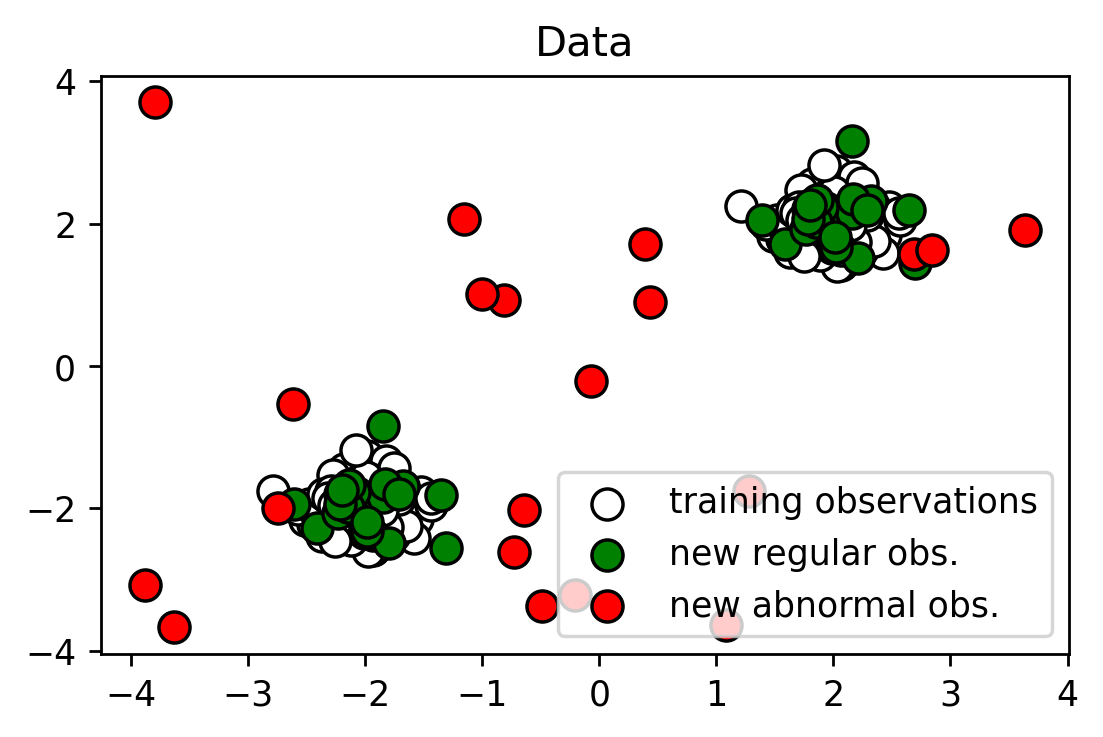

In [40]:
plot_data()

# Local Outlier Factor (LOF) demo

In [45]:
def plot_lof(X, X_scores):
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
    # plot circles with radius proportional to the outlier scores
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    plt.scatter(
        X[:, 0],
        X[:, 1],
        s=1000 * radius,
        edgecolors="r",
        facecolors="none",
        label="Outlier scores",
        alpha=0.7,
    )
    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    legend = plt.legend(loc="upper left")
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()

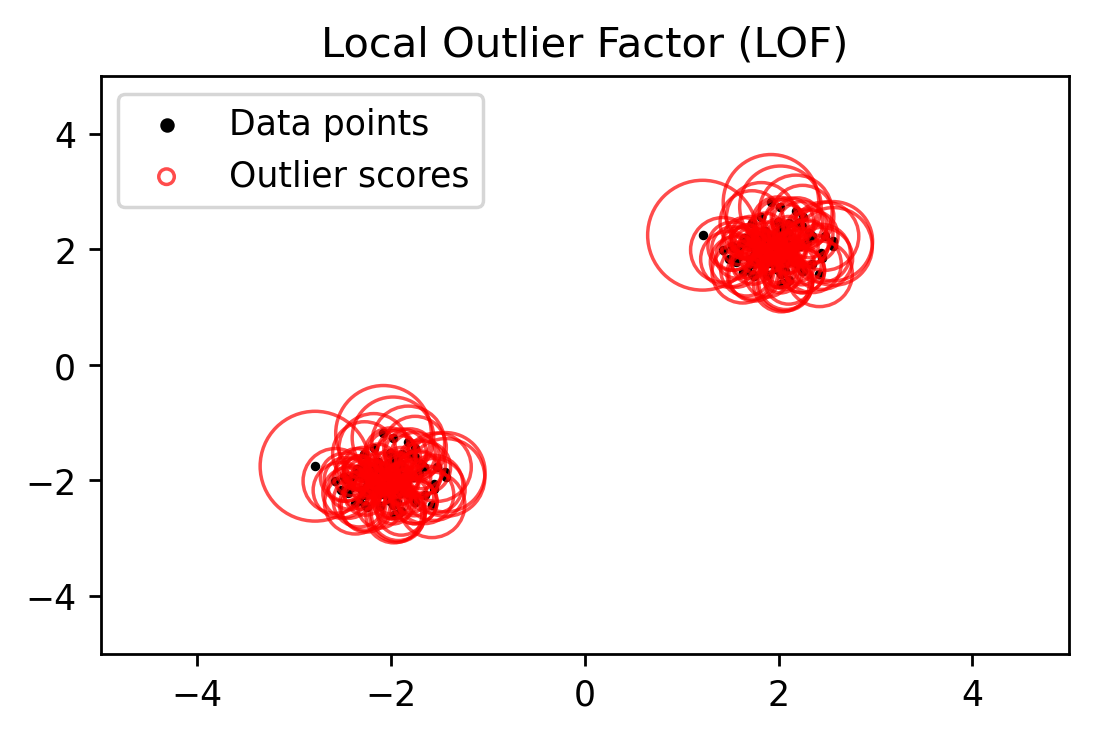

In [46]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X_train)
X_scores = clf.negative_outlier_factor_
plot_lof(X_train, X_scores)

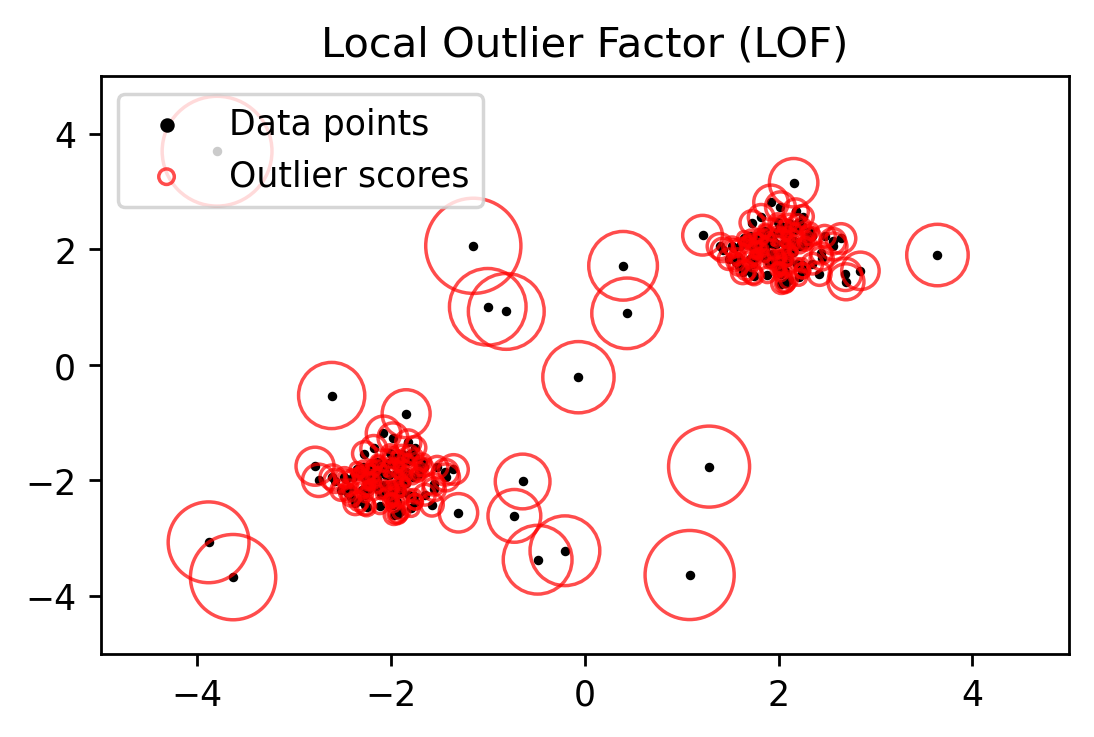

In [47]:
X = np.concatenate((X_train, X_test, X_outliers), axis=0)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_
plot_lof(X, X_scores)

## Isolation forest

In [41]:
# training the model
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=rng)
clf.fit(X_train)

# predictions
y_pred_train = clf.predict(X_train) # 1 nominal, -1 anomalous
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

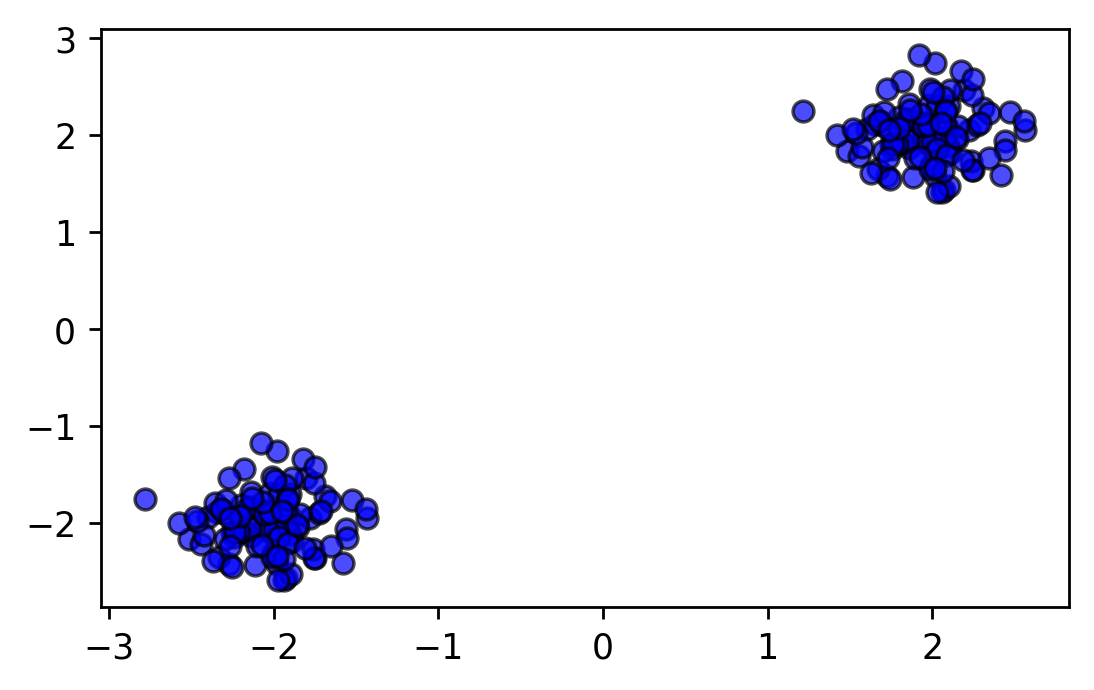

In [42]:
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', edgecolor='k', alpha=0.7)

## Visualization of descision function in 2D space

In [43]:
def plot_descision_function(X, is_anomaly=False):
    x, y = X[:, 0], X[:, 1] 
    plot_step = 0.01
    plt.subplot(1, 1, 1)

    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.scatter(x, y, edgecolor='k', c='r' if is_anomaly else 'g', alpha=0.7)

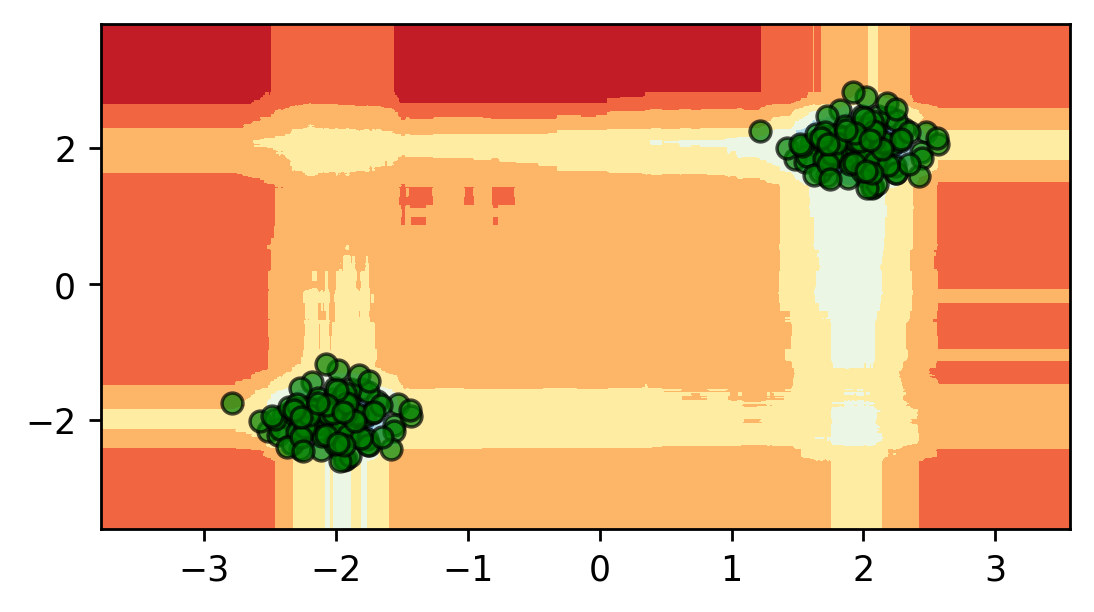

In [12]:
plot_descision_function(X_train, is_anomaly=False)
# plot_descision_function(X_outliers)

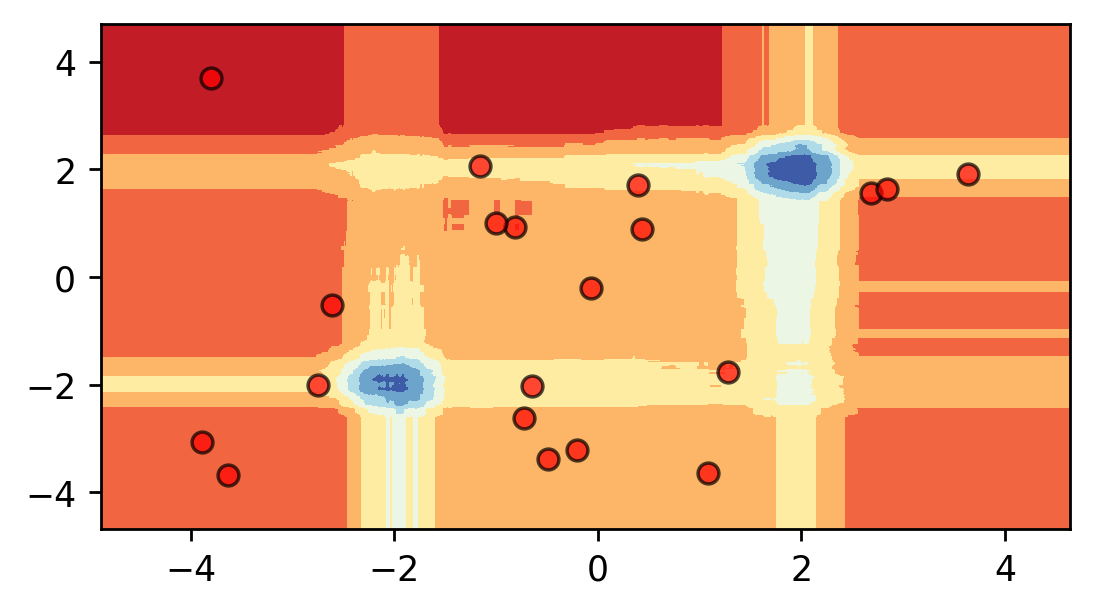

In [13]:
plot_descision_function(X_outliers, is_anomaly=True)

In [14]:
clf.decision_function(X_outliers), clf.decision_function(X_test)[:10]

(array([-0.06983512, -0.13291529, -0.0723264 , -0.07090284, -0.02698176,
        -0.02800688, -0.03813169, -0.03298769, -0.06656255, -0.02286065,
        -0.02322096, -0.11249907, -0.11249907, -0.05818291, -0.06865874,
        -0.06618918, -0.08722434, -0.08000057, -0.07741101, -0.07911495]),
 array([ 0.11904452,  0.00929635,  0.05656287,  0.10346668, -0.0508037 ,
         0.05027603,  0.07407893,  0.1242049 ,  0.13669352,  0.13790652]))

## Digging deeper
- path length
- subsamples

In [44]:
path_lengths = clf.decision_function(X_test)
path_lengths_out = clf.decision_function(X_outliers)

(array([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 1.]),
 array([-0.08548527, -0.08154965, -0.07761403, -0.07367842, -0.0697428 ,
        -0.06580718, -0.06187157, -0.05793595, -0.05400033, -0.05006472,
        -0.0461291 , -0.04219348, -0.03825787, -0.03432225, -0.03038663,
        -0.02645102, -0.0225154 , -0.01857978, -0.01464417, -0.01070855,
        -0.00677293]),
 <BarContainer object of 20 artists>)

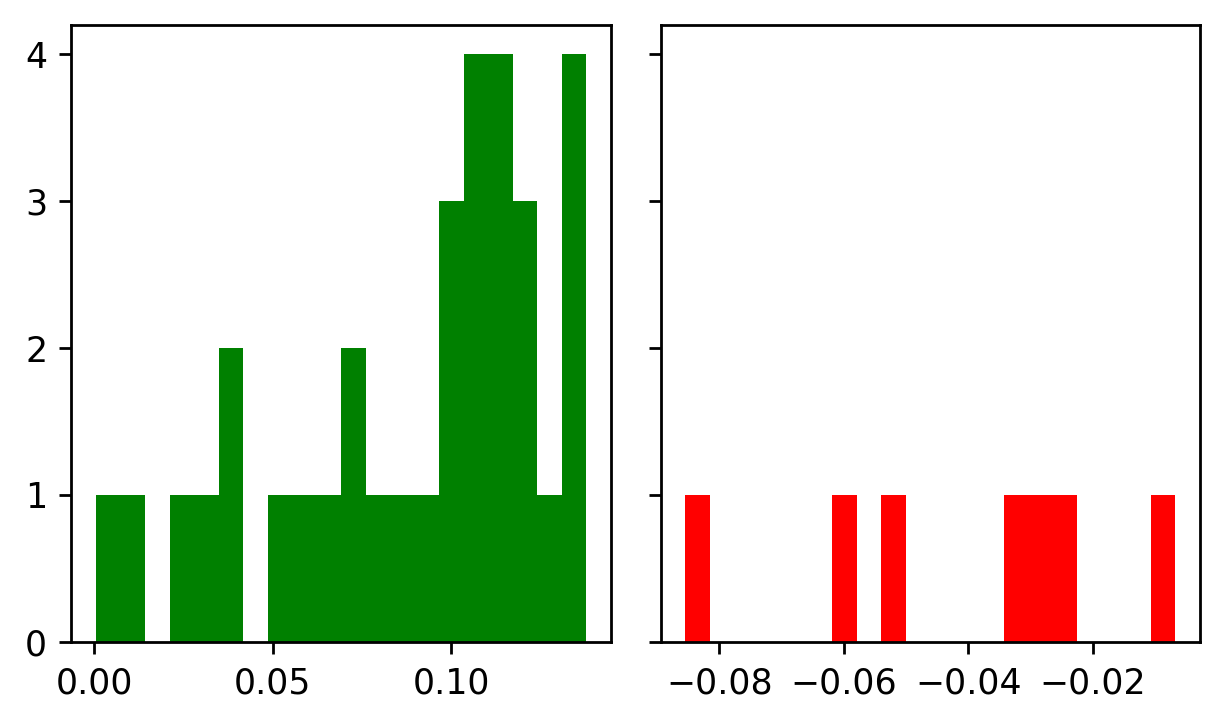

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(path_lengths[np.where(y_pred_test==1)], bins=20, facecolor='g')
axs[1].hist(path_lengths[np.where(y_pred_test==-1)], bins=20, facecolor= 'r')
# axs[1].hist(path_lengths_out[np.where(y_pred_outliers==1)], bins=20, facecolor='g')
# axs[1].hist(path_lengths_out[np.where(y_pred_outliers==-1)], bins=20, facecolor= 'r')

(array([1., 0., 0., 2., 0., 0., 0., 0., 1., 2., 1., 4., 2., 1., 0., 0., 0.,
        1., 1., 4.]),
 array([-0.13291529, -0.12741256, -0.12190983, -0.1164071 , -0.11090436,
        -0.10540163, -0.0998989 , -0.09439617, -0.08889343, -0.0833907 ,
        -0.07788797, -0.07238524, -0.06688251, -0.06137977, -0.05587704,
        -0.05037431, -0.04487158, -0.03936884, -0.03386611, -0.02836338,
        -0.02286065]),
 <BarContainer object of 20 artists>)

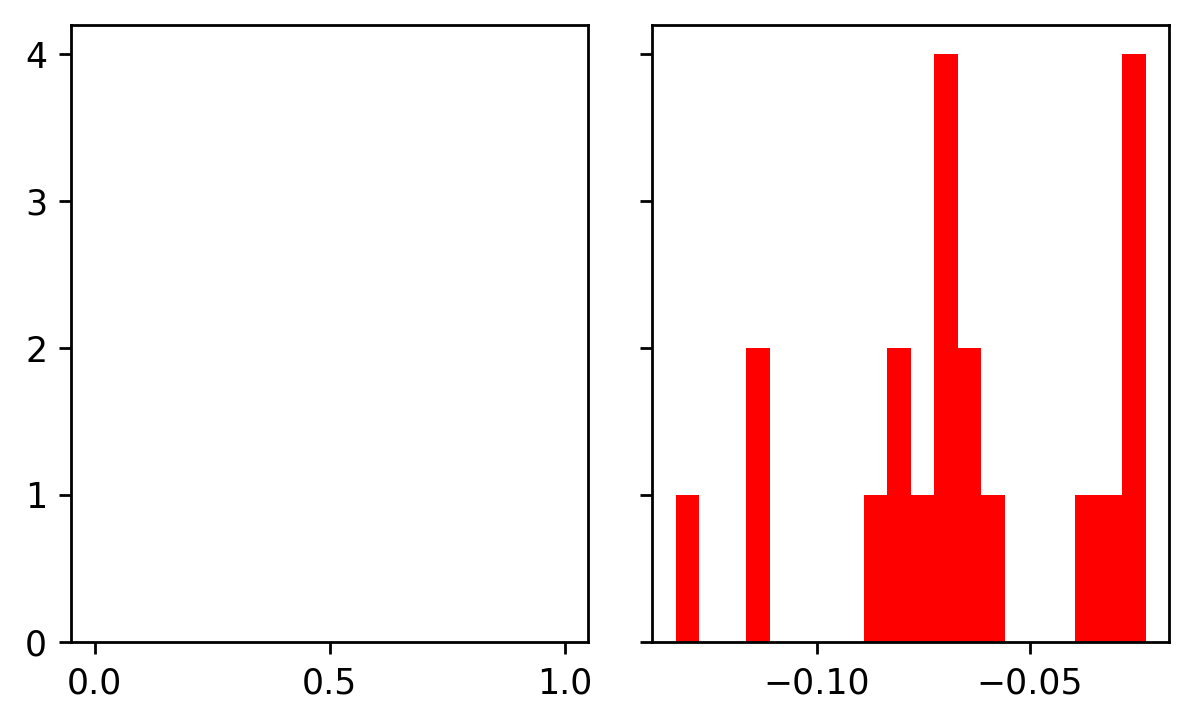

In [17]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#axs[0].hist(path_lengths[np.where(y_pred_test==1)], bins=20, facecolor='g')
#axs[1].hist(path_lengths[np.where(y_pred_test==-1)], bins=20, facecolor= 'r')
axs[0].hist(path_lengths_out[np.where(y_pred_outliers==1)], bins=20, facecolor='g')
axs[1].hist(path_lengths_out[np.where(y_pred_outliers==-1)], bins=20, facecolor= 'r')

## Plot a single _iTree_

/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


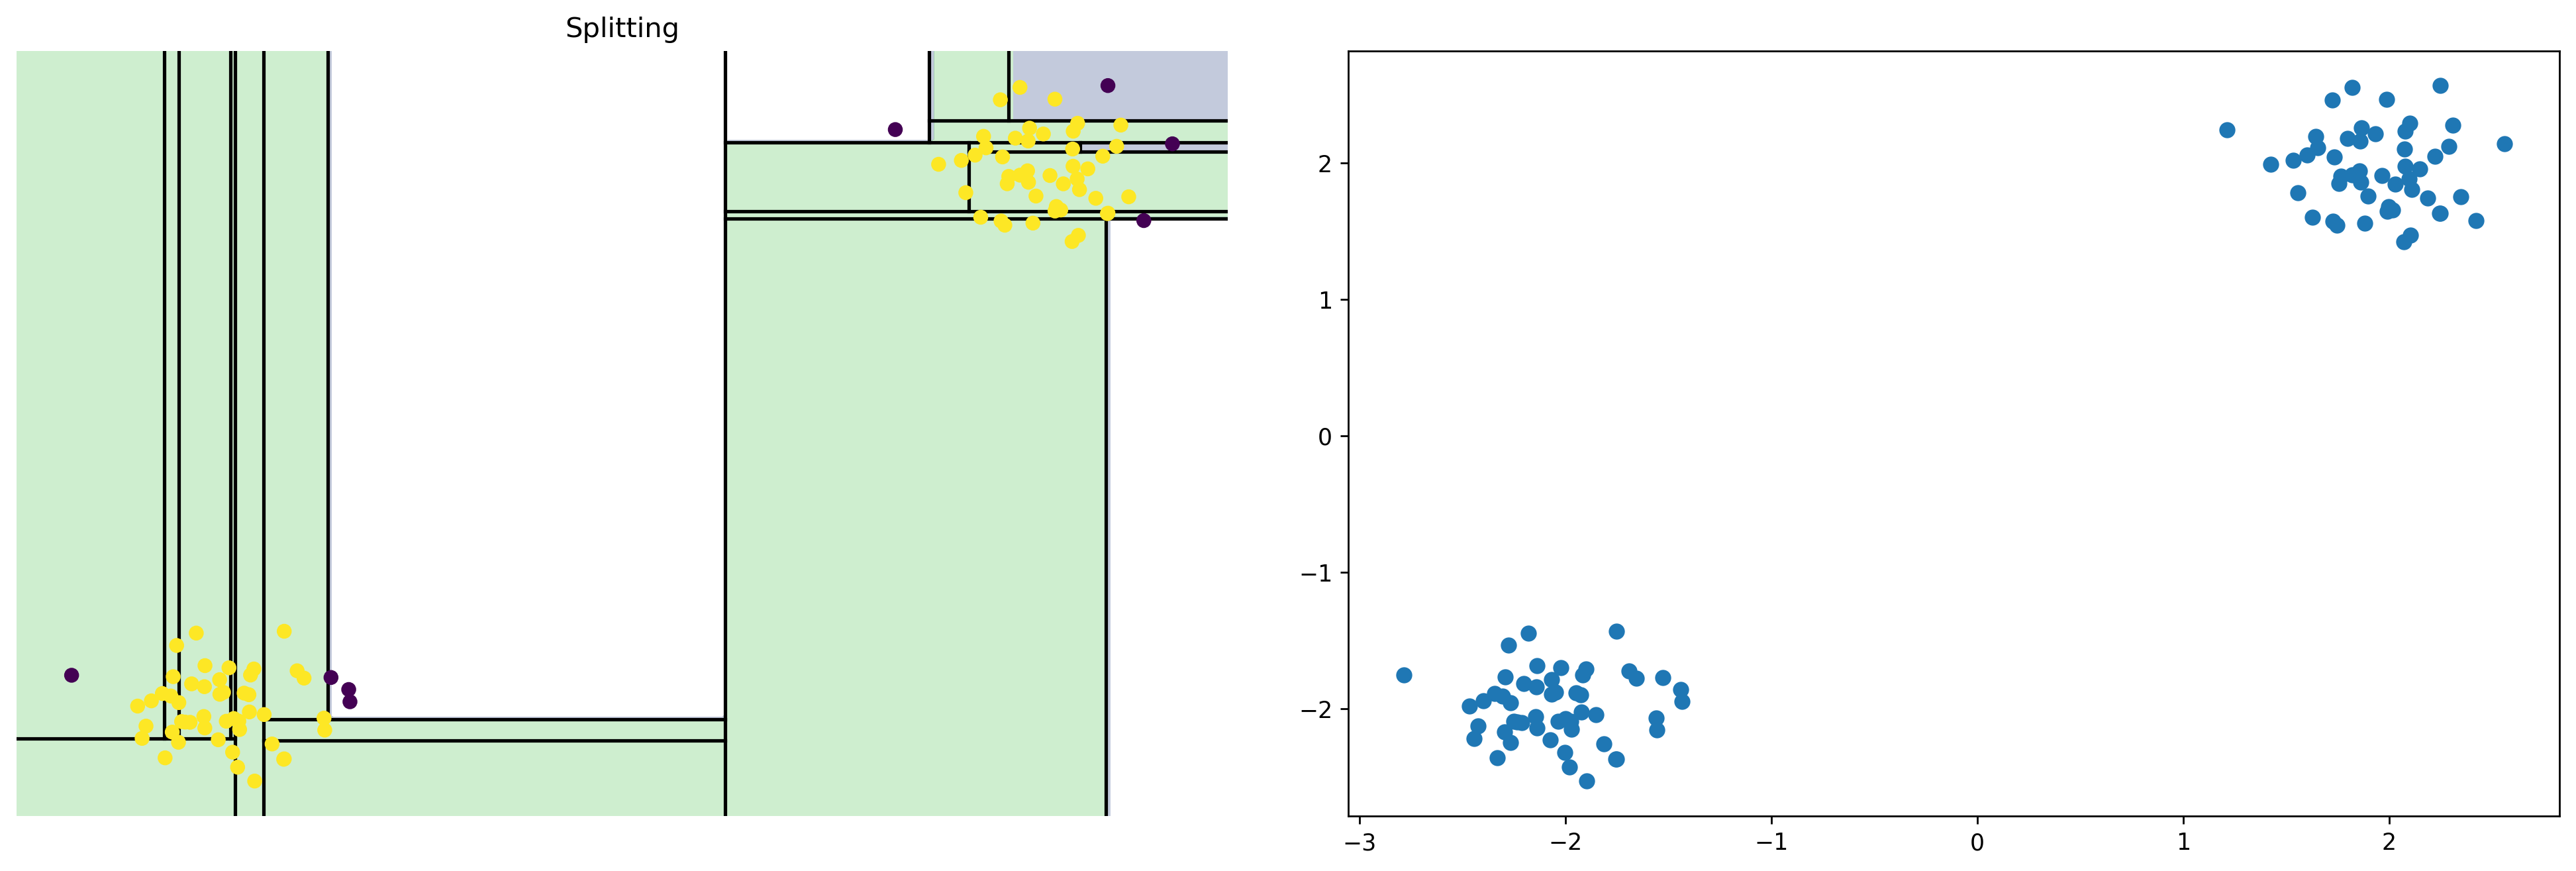

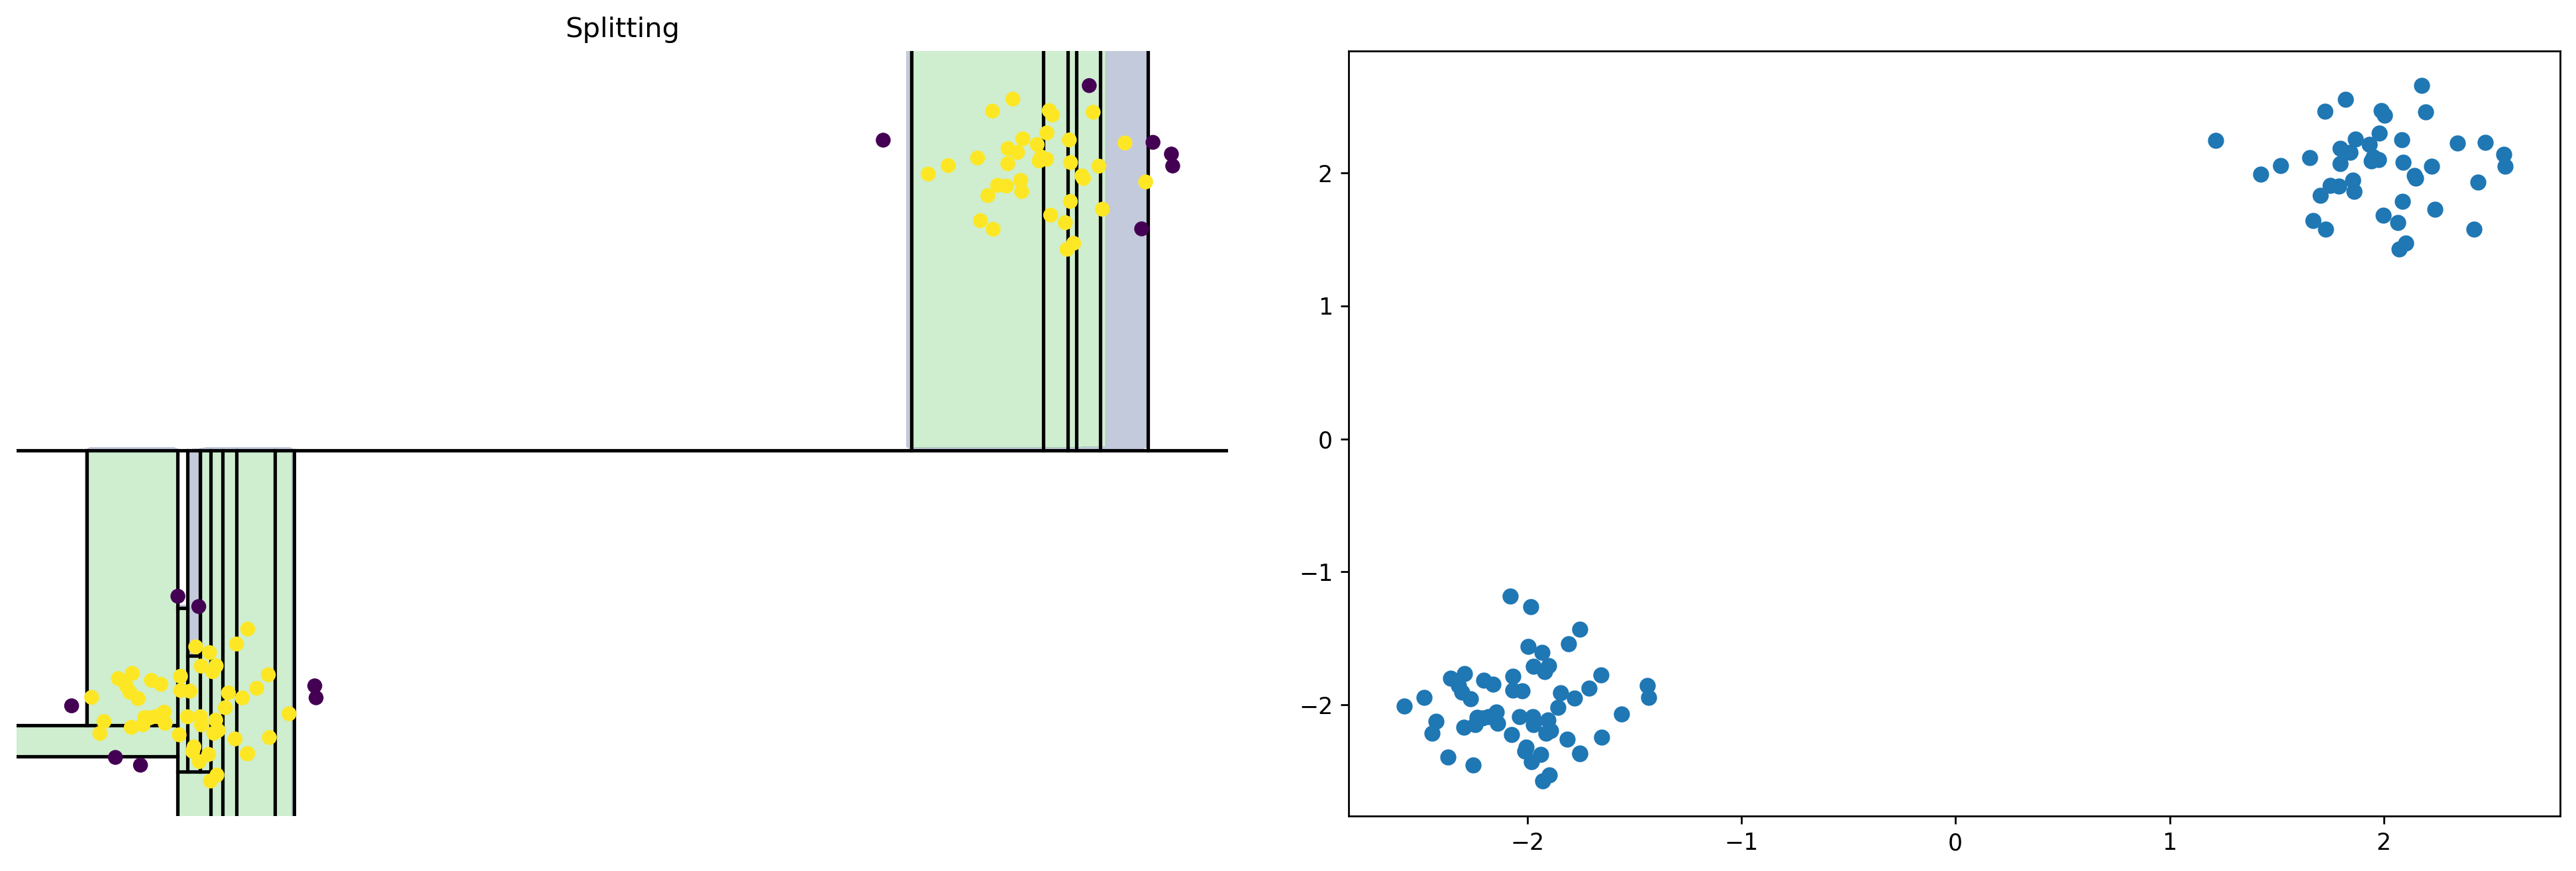

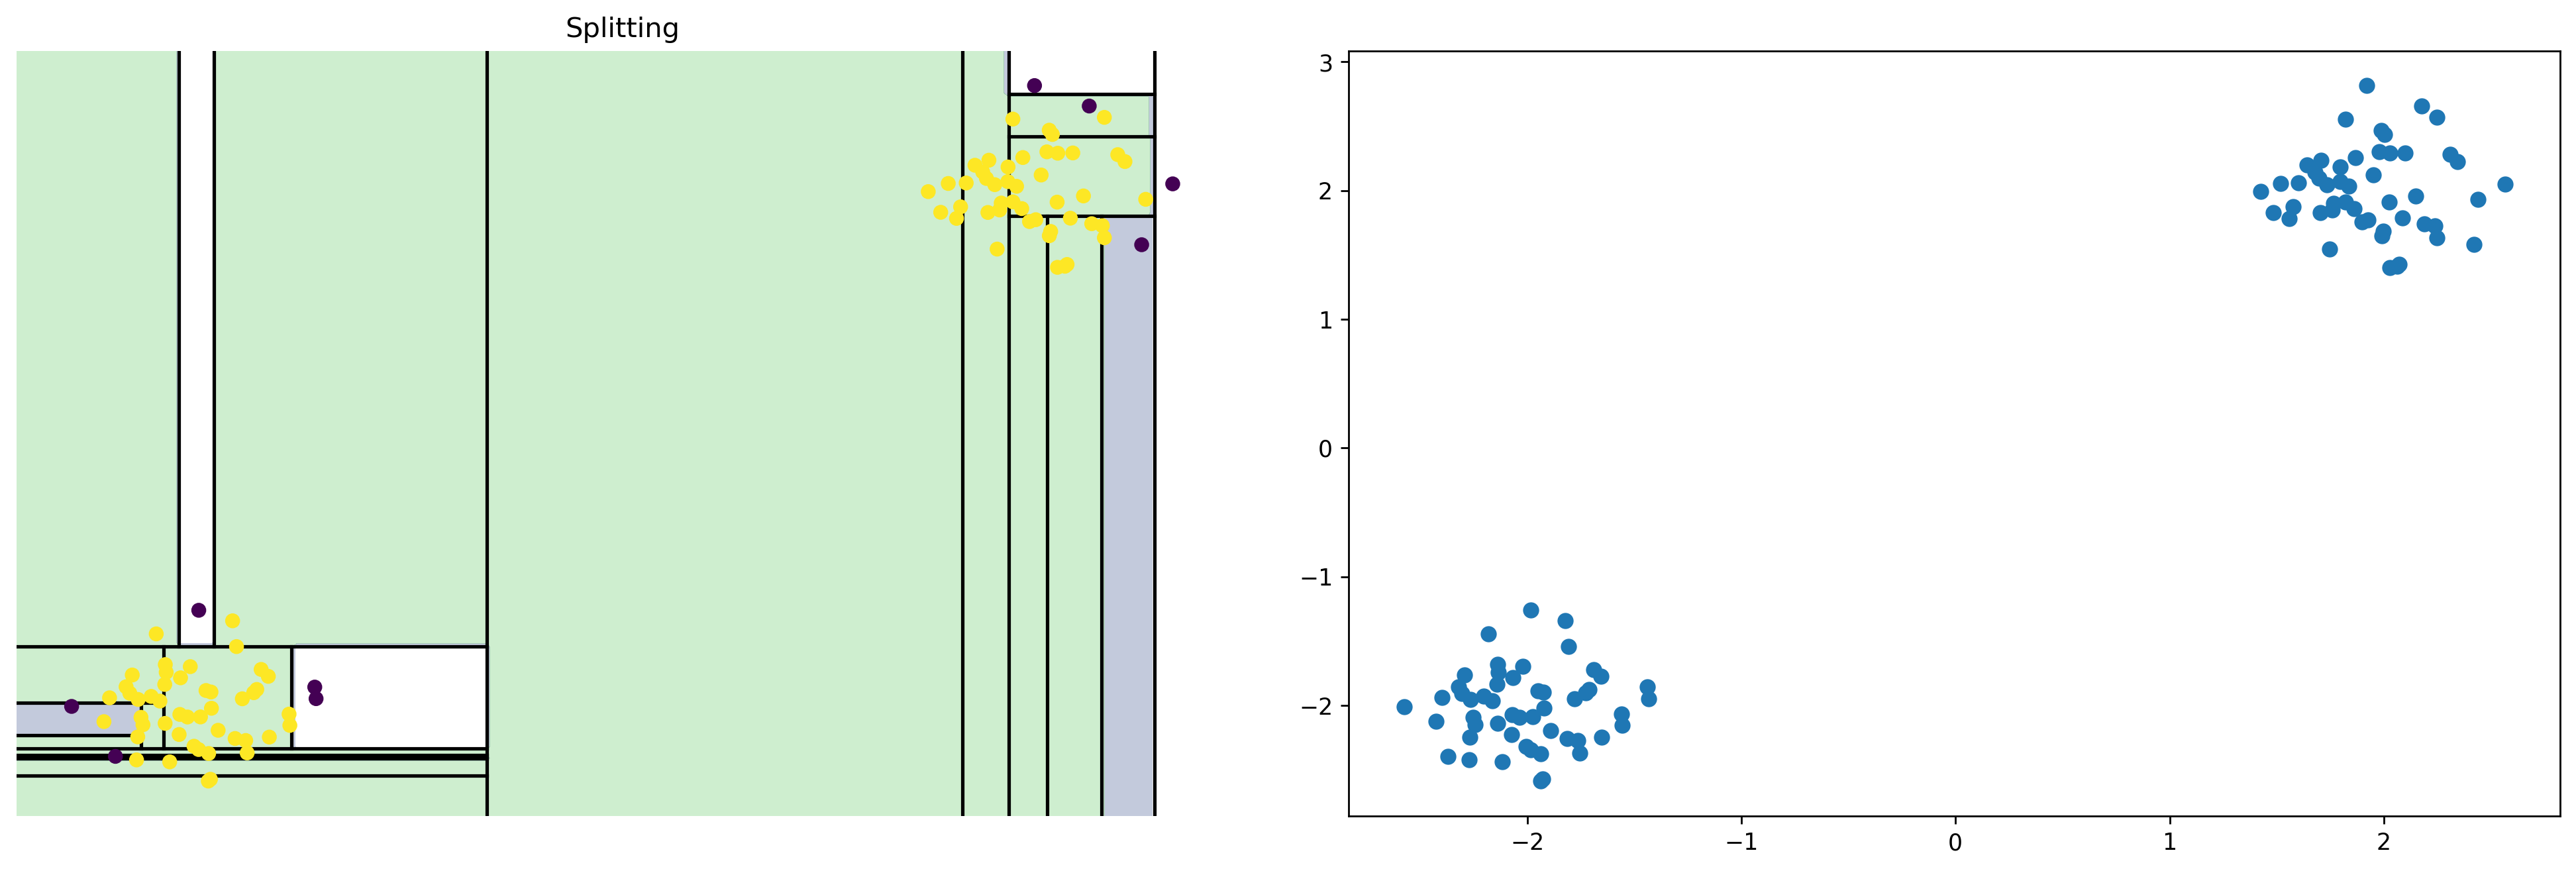

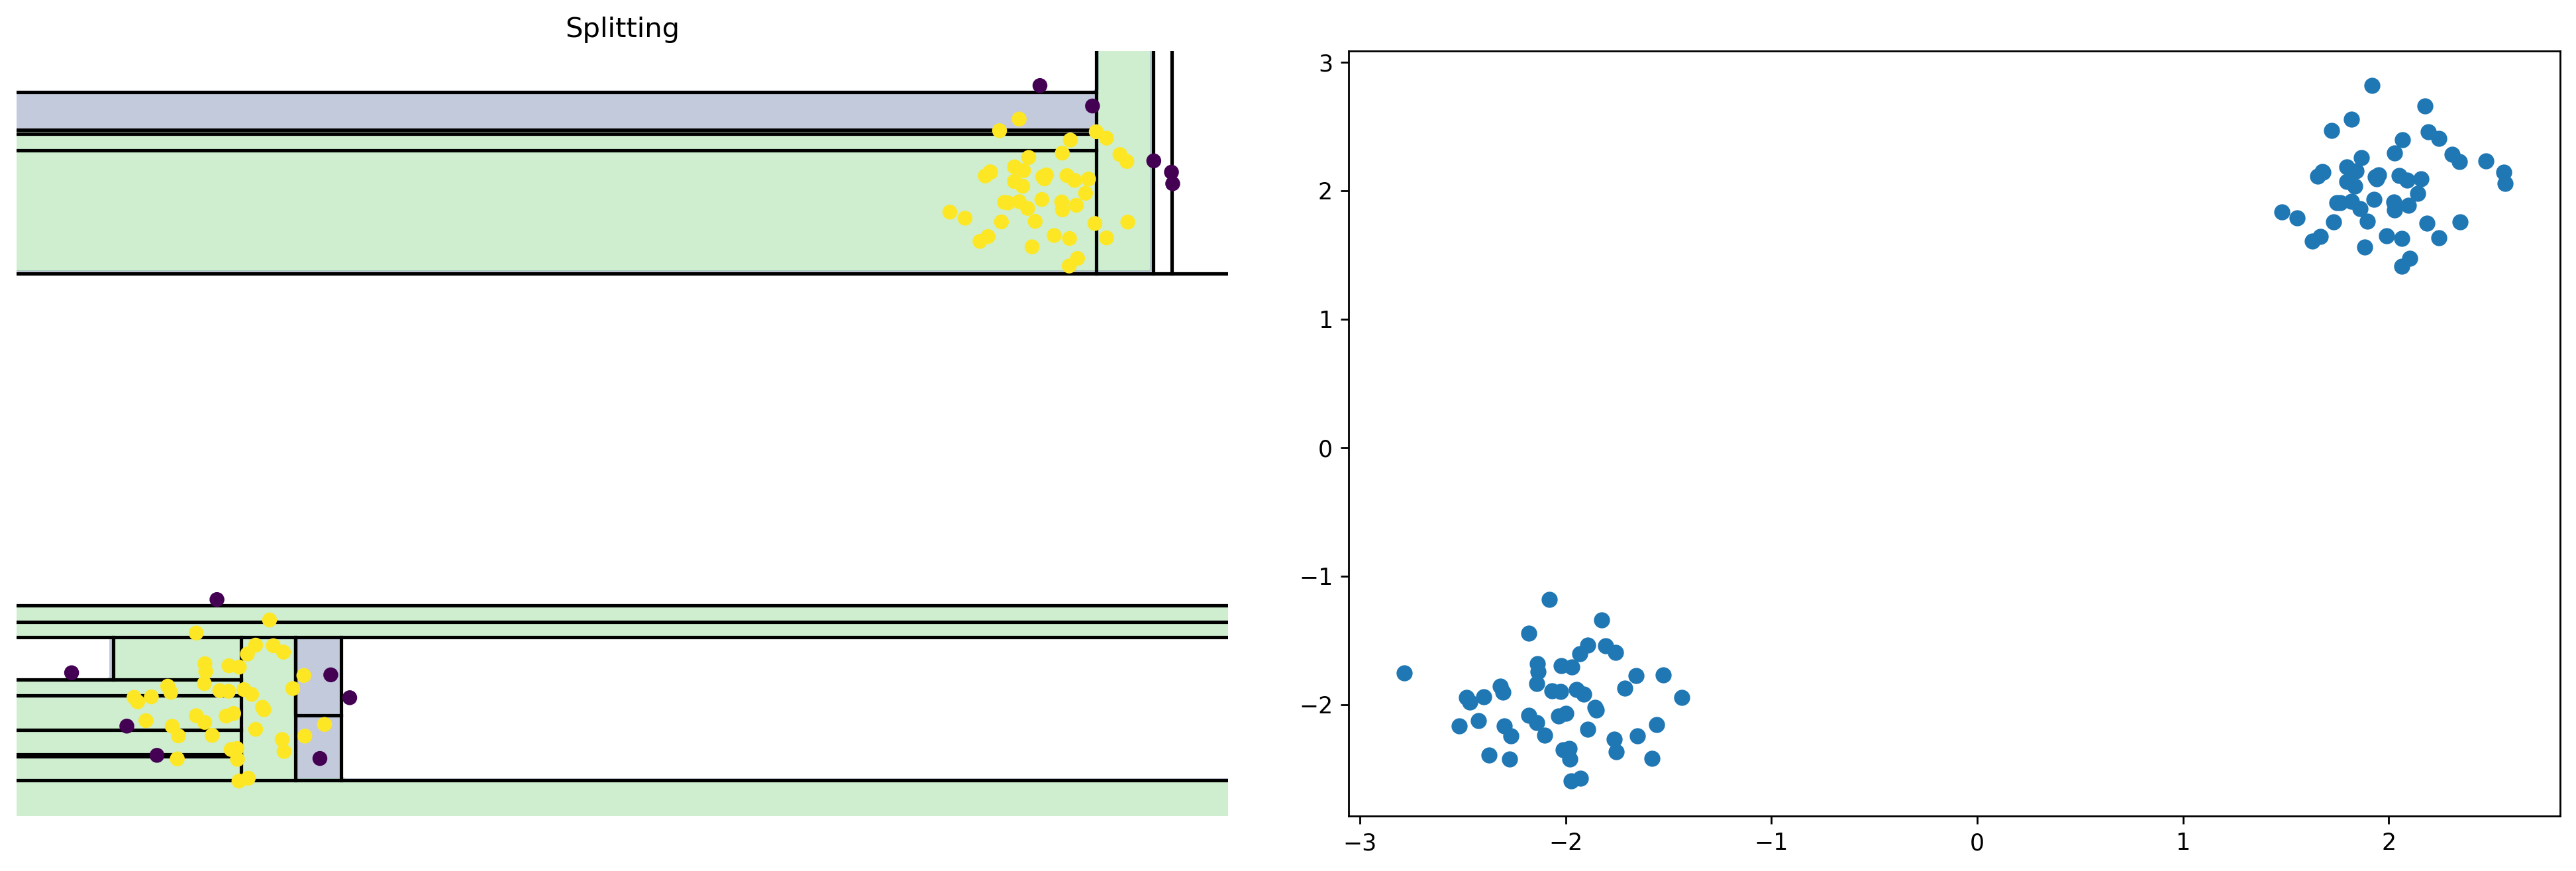

In [19]:
from helpers_05_08 import visualize_tree
from sklearn.tree import DecisionTreeClassifier

for idx_tree in range(4):
        
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

    index = clf.estimators_samples_[idx_tree]
    plt.scatter(X_train[index, 0], X_train[index, 1])
    y = clf.predict(X_train)
    for axi, depth in zip(ax, range(1, 2)):
        model = clf.estimators_[idx_tree]
        visualize_tree(model, X_train[index], y[index], ax=axi)
        axi.set_title('Splitting'.format(depth))

/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The follo

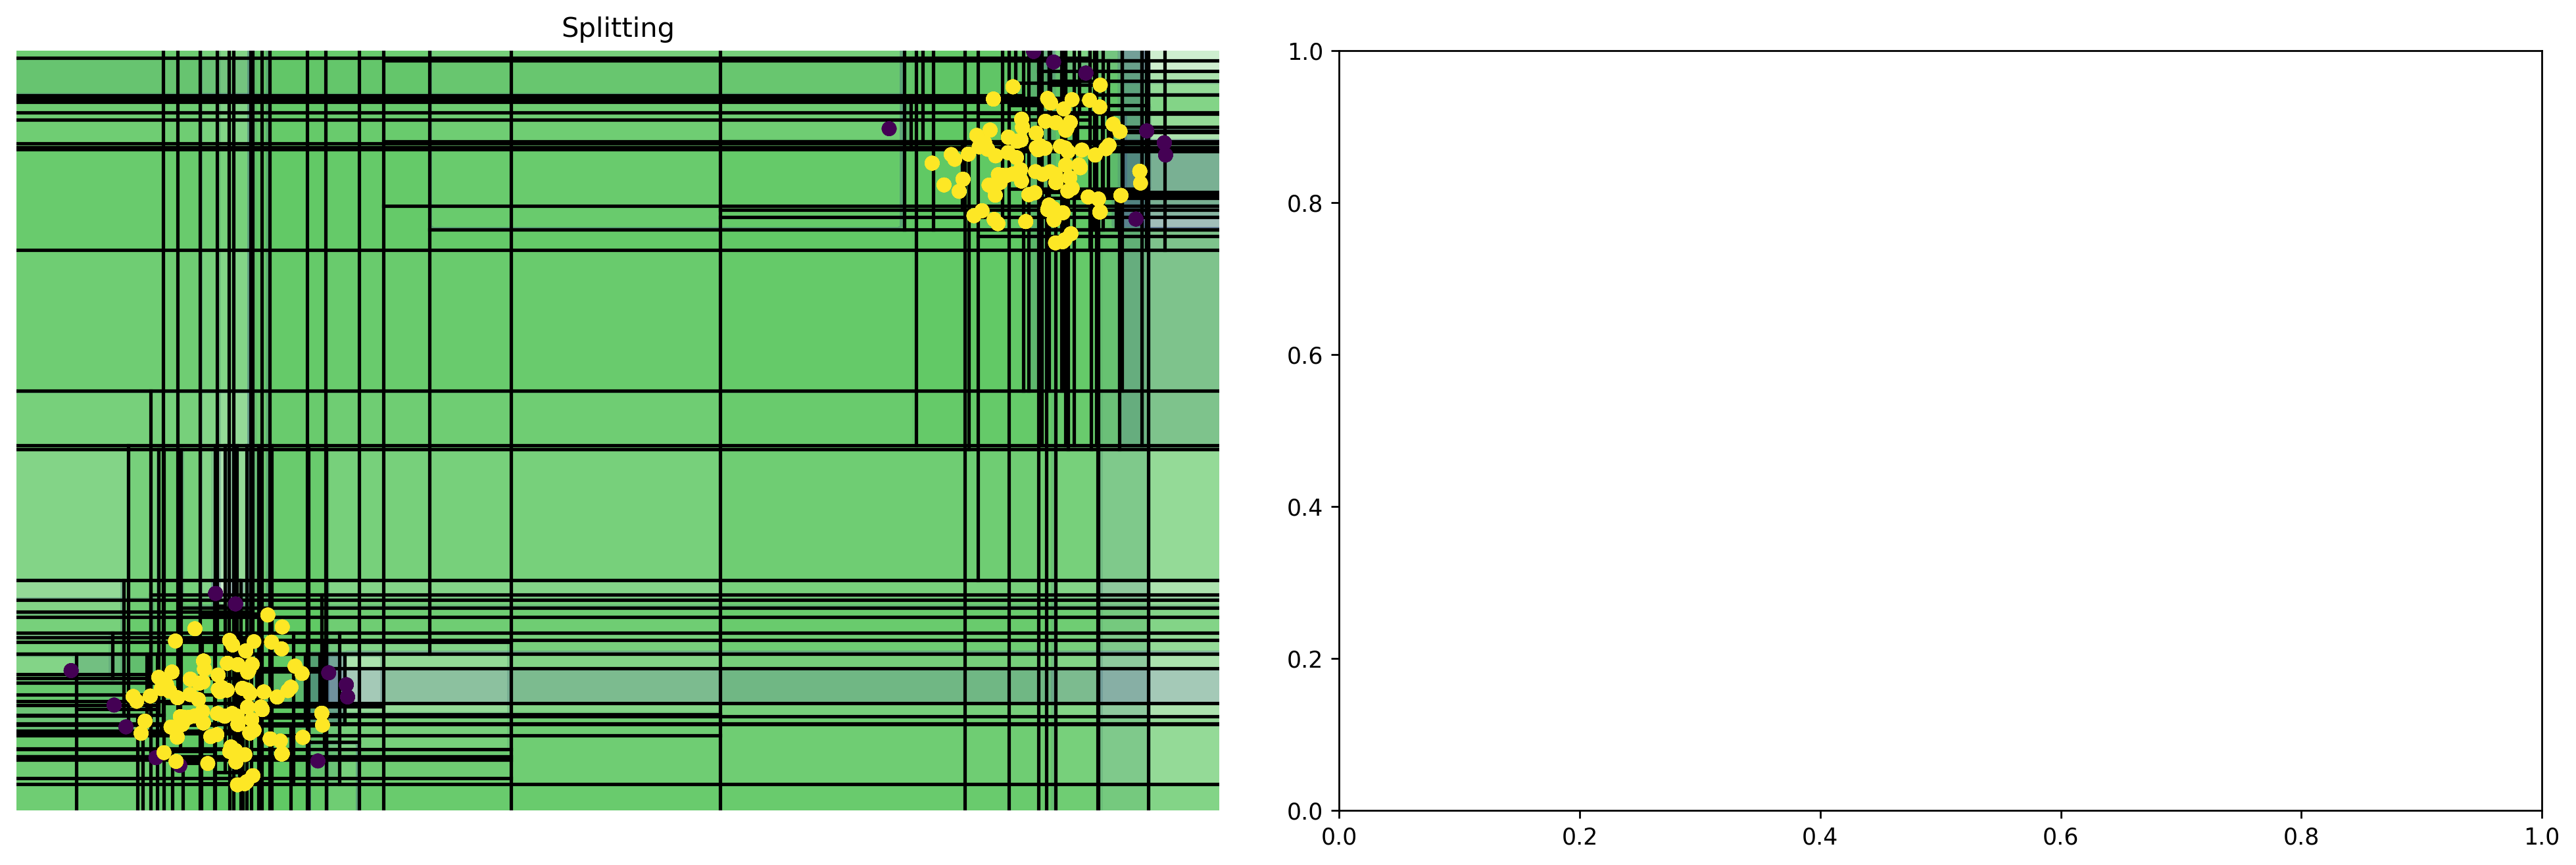

In [20]:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
for idx_tree in range(10):
        
    index = clf.estimators_samples_[idx_tree]
#     plt.scatter(X_train[index, 0], X_train[index, 1])
    y = clf.predict(X_train)
    for axi, depth in zip(ax, range(1)):
        model = clf.estimators_[idx_tree]
        visualize_tree(model, X_train[index], y[index], ax=axi)
        axi.set_title('Splitting'.format(depth))

[[ 0.02458305  2.96215652]
 [-1.52392631  7.12573205]
 [ 1.27450825  5.63017322]
 [-0.86552334  7.80121774]
 [ 0.74874067  2.55579434]]
[1 3 0 3 1]


/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
/Users/rakib/Documents/class/anomaly-detection/helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


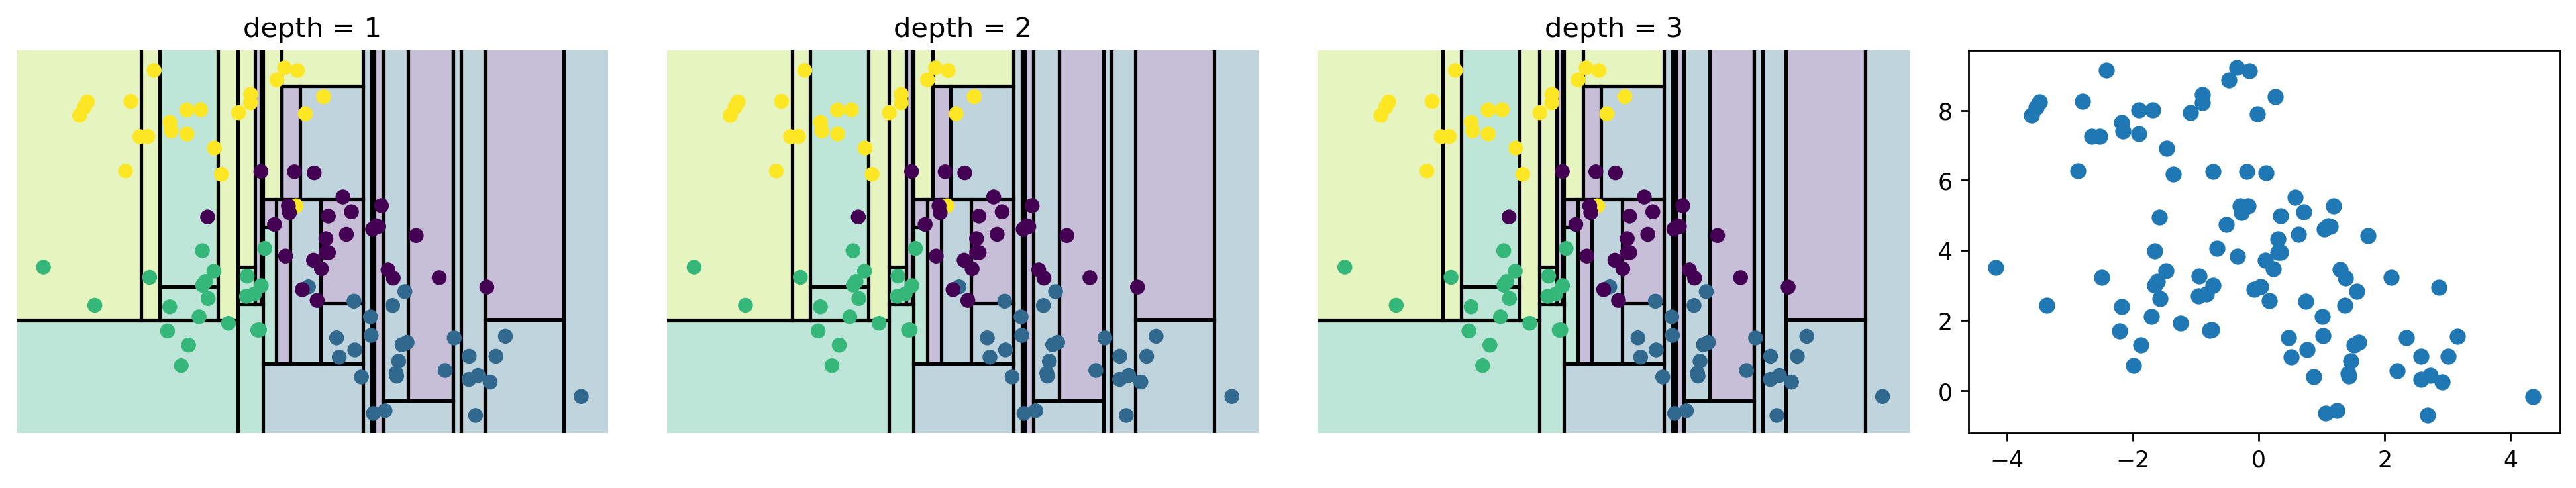

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
print(X[:5])
print(y[:5])
index = clf.estimators_samples_[0]
plt.scatter(X[index, 0], X[index, 1])

for axi, depth in zip(ax, range(1, 4)):
    # model = DecisionTreeClassifier(max_depth=depth)
    model = clf.estimators_[0]
    visualize_tree(model, X[index], y[index], ax=axi)
    axi.set_title('depth = {0}'.format(depth))

## Evaluation of anomaly detection

In [48]:
# new, 'normal' observations
print("Accuracy y_pred test:", list(y_pred_test).count(1)/y_pred_test.shape[0])

Accuracy y_pred test: 0.825


In [49]:
# new, 'normal' observations
print("Accuracy y_pred outliers:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

Accuracy y_pred outliers: 1.0


In [50]:
import numpy as np
from sklearn.metrics import roc_auc_score

In [51]:
y = np.r_[y_pred_test, y_pred_outliers]

In [52]:
y

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [33]:
y_true = np.r_[[1] * len(y_pred_test),[-1] * len(y_pred_outliers)]

In [34]:
# y_true.extend([-1] * len(y_pred_outliers))

In [35]:
print(roc_auc_score(y_true, y))

0.9125
